In [27]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
from joblib import load

In [3]:
data_dir = Path.cwd().parent / 'DATA'

In [4]:
# define target column
TARGET = "contest-tmp2m-14d__tmp2m"

In [5]:
pd.set_option('display.max_columns', 500)

## 1. Load Test Data

In [6]:
LOAD_KEY = 200
MODEL_LABEL = 'second_draft'
MODEL_DATE = '2023-02-23'
MODEL_TRIAL = 4

In [7]:
test_datafile = data_dir / f"{LOAD_KEY}_test_lagged.parquet"

In [8]:
test_df = pd.read_parquet(test_datafile)

In [9]:
info_cols = ["index", "date", "location", "split", "year"]

In [10]:
feature_cols = [c for c in test_df.columns if c not in info_cols]
print(f"selected {len(feature_cols)} features")

selected 64 features


In [11]:
pred_df = test_df.loc[:, feature_cols]
print(f"prediction dataframe -> rows: {pred_df.shape[0]}, cols: {pred_df.shape[1]}")

prediction dataframe -> rows: 31354, cols: 64


In [12]:
pred_df.head()

,lat,lon,elevation__elevation,contest-pevpr-sfc-gauss-14d__pevpr,contest-rhum-sig995-14d__rhum,contest-prwtr-eatm-14d__prwtr,contest-precip-14d__precip,contest-wind-h10-14d__wind-hgt-10,contest-wind-h100-14d__wind-hgt-100,contest-wind-h850-14d__wind-hgt-850,contest-wind-h500-14d__wind-hgt-500,wind-hgt-850-2010-10,wind-hgt-500-2010-10,wind-hgt-10-2010-10,wind-hgt-100-2010-10,contest-slp-14d__slp,contest-pres-sfc-gauss-14d__pres,contest-wind-vwnd-925-14d__wind-vwnd-925,contest-wind-vwnd-250-14d__wind-vwnd-250,wind-vwnd-250-2010-10,wind-vwnd-925-2010-10,contest-wind-uwnd-250-14d__wind-uwnd-250,contest-wind-uwnd-925-14d__wind-uwnd-925,wind-uwnd-250-2010-10,wind-uwnd-925-2010-10,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,sst-2010-10,icec-2010-10,week,month,day_of_year,contest-pevpr-sfc-gauss-14d__pevpr__lag1,contest-rhum-sig995-14d__rhum__lag1,contest-prwtr-eatm-14d__prwtr__lag1,contest-precip-14d__precip__lag1,contest-wind-h10-14d__wind-hgt-10__lag1,contest-wind-h100-14d__wind-hgt-100__lag1,contest-wind-h850-14d__wind-hgt-850__lag1,contest-wind-h500-14d__wind-hgt-500__lag1,wind-hgt-850-2010-10__lag1,wind-hgt-500-2010-10__lag1,wind-hgt-10-2010-10__lag1,wind-hgt-100-2010-10__lag1,contest-slp-14d__slp__lag1,contest-pres-sfc-gauss-14d__pres__lag1,contest-wind-vwnd-925-14d__wind-vwnd-925__lag1,contest-wind-vwnd-250-14d__wind-vwnd-250__lag1,wind-vwnd-250-2010-10__lag1,wind-vwnd-925-2010-10__lag1,contest-wind-uwnd-250-14d__wind-uwnd-250__lag1,contest-wind-uwnd-925-14d__wind-uwnd-925__lag1,wind-uwnd-250-2010-10__lag1,wind-uwnd-925-2010-10__lag1,mjo1d__phase__lag1,mjo1d__amplitude__lag1,mei__mei__lag1,mei__meirank__lag1,mei__nip__lag1,sst-2010-10__lag1,icec-2010-10__lag1
0,0.0,0.833333,200,339.88,72.04,40.29,34.85,31233.02,16700.13,1549.82,5916.86,474.25,768.56,2047.99,-812.00,101441.09,98734.98,3.12,-4.82,72.60,-1.75,1.14,-4.38,69.67,53.86,1.0,0.69,0.19,37.0,3.0,25.02,0.13,44,11,304,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
1,0.0,0.833333,200,334.63,71.93,40.15,27.46,31230.63,16697.68,1550.55,5917.85,377.67,740.11,2474.83,-749.08,101449.71,98745.78,3.22,-4.34,67.94,7.36,0.55,-4.50,50.82,55.91,8.0,0.31,0.19,37.0,3.0,25.72,0.13,44,11,305,339.88,72.04,40.29,34.85,31233.02,16700.13,1549.82,5916.86,474.25,768.56,2047.99,-812.00,101441.09,98734.98,3.12,-4.82,72.60,-1.75,1.14,-4.38,69.67,53.86,1.0,0.69,0.19,37.0,3.0,25.02,0.13
2,0.0,0.833333,200,337.83,72.43,40.07,24.65,31225.26,16694.94,1550.16,5918.56,212.99,602.57,2537.81,-656.16,101446.14,98743.07,3.42,-3.62,66.51,13.13,0.12,-4.61,30.57,59.76,4.0,0.27,0.19,37.0,3.0,26.15,0.13,44,11,306,334.63,71.93,40.15,27.46,31230.63,16697.68,1550.55,5917.85,377.67,740.11,2474.83,-749.08,101449.71,98745.78,3.22,-4.34,67.94,7.36,0.55,-4.50,50.82,55.91,8.0,0.31,0.19,37.0,3.0,25.72,0.13
3,0.0,0.833333,200,345.81,71.88,40.00,22.43,31220.87,16692.18,1550.15,5920.30,47.14,392.55,2299.39,-615.87,101443.27,98748.59,3.82,-2.80,75.15,16.43,0.26,-4.49,13.11,59.26,3.0,0.44,0.19,37.0,3.0,26.35,0.13,44,11,307,337.83,72.43,40.07,24.65,31225.26,16694.94,1550.16,5918.56,212.99,602.57,2537.81,-656.16,101446.14,98743.07,3.42,-3.62,66.51,13.13,0.12,-4.61,30.57,59.76,4.0,0.27,0.19,37.0,3.0,26.15,0.13
4,0.0,0.833333,200,357.39,71.18,39.80,16.31,31214.54,16689.71,1551.19,5923.03,-4.41,178.82,1733.94,-573.38,101448.09,98761.84,3.91,-2.59,91.43,15.96,0.65,-4.34,-4.37,58.39,3.0,0.53,0.19,37.0,3.0,26.51,0.13,44,11,308,345.81,71.88,40.00,22.43,31220.87,16692.18,1550.15,5920.30,47.14,392.55,2299.39,-615.87,101443.27,98748.59,3.82,-2.80,75.15,16.43,0.26,-4.49,13.11,59.26,3.0,0.44,0.19,37.0,3.0,26.35,0.13


## 2. Load Model & Predict

In [13]:
artifact_dir = Path.cwd() / 'artifacts'

In [14]:
mdl_prfx = f"{MODEL_LABEL}{MODEL_TRIAL}_{MODEL_DATE}"

In [15]:
mdl_param_file = artifact_dir / f"{mdl_prfx}.json"

In [16]:
with open(mdl_param_file, 'r') as js_in:
    mdl_params = json.load(js_in)

In [17]:
mdl_file = artifact_dir / f"{mdl_prfx}.joblib"

In [18]:
reg = load(mdl_file)

In [19]:
%%time
pred = reg.predict(pred_df)

CPU times: total: 1.78 s
Wall time: 161 ms


## 3. Review Output

In [20]:
TARGET = mdl_params['target']
target_col = TARGET['name']
target_min = TARGET['min']
target_delta = TARGET['delta']
print(f"{target_col} range -> min: {target_min}, max: {target_min + target_delta}")

contest-tmp2m-14d__tmp2m range -> min: -20.35896342, max: 37.23878207


In [21]:
FIG_SIZE = (15,9)

In [22]:
pred_df = pd.DataFrame(data=pred, index=test_df['index'], columns=[target_col])
# pred_df[target_col] = target_min + pred_df[target_col] * target_delta
pred_df = pred_df.reset_index()
pred_df = pred_df[[target_col, 'index']]
pred_df.head()

,contest-tmp2m-14d__tmp2m,index
0,28.162178,375734
1,28.911118,375735
2,28.726288,375736
3,28.994520,375737
4,29.143162,375738


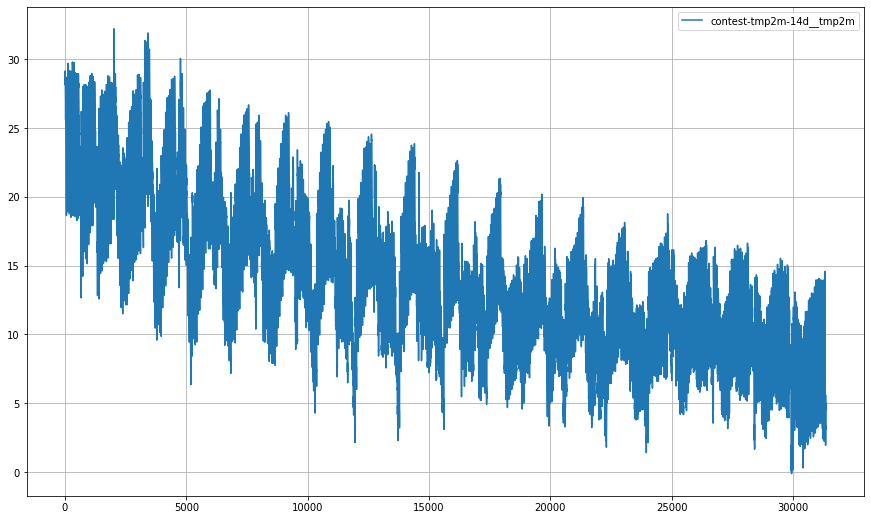

In [23]:
pred_df.plot.line(y=target_col, figsize=FIG_SIZE)
plt.grid()
plt.show()

## 4. Output Solution

In [24]:
out_csv = artifact_dir / f"{mdl_prfx}.csv"

In [25]:
pred_df.to_csv(out_csv, index=False)